In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
 # 制作数据集
class MyData(Dataset): # 继承 Dataset 类
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0) # 导入数据
        arr = df.values # 对象退化为数组
        arr = arr.astype(np.float32) # 转为 float32 类型数组
        ts = torch.tensor(arr) # 数组转为张量
        ts = ts.to('cuda') # 把训练集搬到 cuda 上
        self.X = ts[ : , : -1 ] # 前 8 列为输入特征
        self.Y = ts[ : , -1 ].reshape((-1,1)) # 后 1 列为输出特征
        self.len = ts.shape[0] # 样本的总数
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [4]:
 # 划分训练集与测试集
Data = MyData(r'D:\AllDocument\Msc\Applied Data Science and Applications in Social Policy\Project\merged_2.csv')
train_size = int(len(Data) * 0.7) # 训练集的样本数量
test_size = len(Data) - train_size # 测试集的样本数量
train_Data, test_Data = random_split(Data, [train_size, test_size])


In [43]:
# 批次加载器
train_loader = DataLoader(dataset=train_Data, shuffle=True, batch_size=208000)
test_loader = DataLoader(dataset=test_Data, shuffle=False, batch_size=6400)


In [44]:
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
            nn.Linear(940, 1000), nn.ReLU(), # 第 1 层：全连接层
            nn.Linear(1000, 500), nn.ReLU(), # 第 2 层：全连接层
            nn.Linear(500, 250), nn.ReLU(), # 第 3 层：全连接层
            nn.Linear(250,100),nn.ReLU(),
            nn.Linear(100, 1),  # 第 4 层：全连接层
        )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [45]:
model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=940, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [46]:
 # 损失函数的选择
loss_fn = nn.MSELoss()

In [47]:
# 优化算法的选择
learning_rate = 0.0001 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

当你设置 CUDA_LAUNCH_BLOCKING 为 "1" 时，CUDA操作将变为同步模式。这意味着每次调用CUDA API（如核函数）时，主机代码都会等待直到该操作完成。这通常用于调试目的，因为它可以帮助开发者确定程序在哪个点上卡住或崩溃。然而，在生产环境中，通常不推荐使用同步模式，因为它会显著降低性能，因为GPU和CPU不能并行工作。

相反，如果将 CUDA_LAUNCH_BLOCKING 设置为 "0"（这是默认值），CUDA操作将变为异步模式，允许GPU和CPU同时执行操作，从而提高性能。

In [49]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=10)

In [50]:
epochs = 1000
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
        scheduler.step()



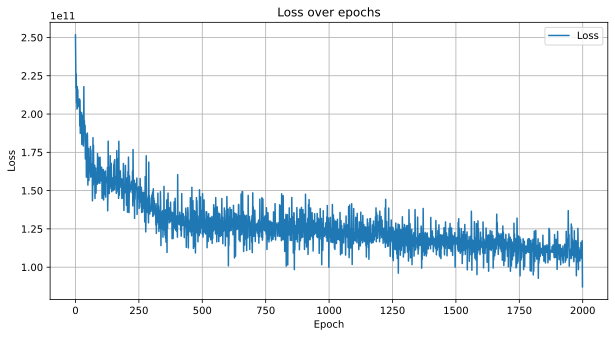

In [51]:
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.plot(losses, label='Loss')  # 绘制损失函数的变化
plt.title('Loss over epochs')  # 设置图表标题
plt.xlabel('Epoch')  # 设置x轴标签
plt.ylabel('Loss')  # 设置y轴标签
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图表

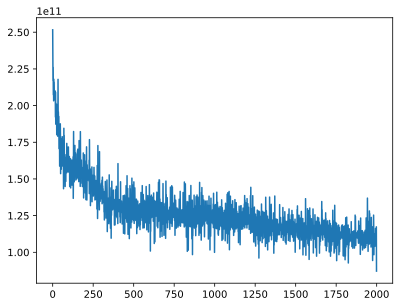

In [52]:
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [53]:
data_array = np.array(losses)

# 计算描述性统计量
mean_value = np.mean(data_array)
median_value = np.median(data_array)
std_dev = np.std(data_array)
variance = np.var(data_array)

# 打印结果
print(f'Mean: {mean_value}')
print(f'Median: {median_value}')
print(f'Standard Deviation: {std_dev}')
print(f'Variance: {variance}')

Mean: 127246715584.512
Median: 123018555392.0
Standard Deviation: 18568244106.10019
Variance: 3.447796891837244e+20


In [54]:
# 初始化总样本数和总MSE
total = 0
mse_total = 0.0

with torch.no_grad():  # 该局部关闭梯度计算功能
    for x, y in test_loader:  # 获取小批次的 x 与 y
        Pred = model(x)  # 一次前向传播（小批量）
        total += y.size(0)  # 更新总样本数
        mse = torch.mean((y - Pred) ** 2)  # 计算当前批次的均方误差
        mse_total += mse * y.size(0)  # 累加均方误差

# 计算平均均方误差
mse_average = mse_total / total

print(f'测试集均方误差: {mse_average}')

测试集均方误差: 104538652672.0


In [55]:
# 如果你还想计算平均绝对误差(MAE)，可以按以下方式做
mae_total = 0.0

with torch.no_grad():
    for x, y in test_loader:
        Pred = model(x)
        total += y.size(0)  # 确保这个也在MAE的循环中
        mae = torch.mean(torch.abs(y - Pred))  # 计算当前批次的平均绝对误差
        mae_total += mae * y.size(0)  # 累加平均绝对误差

# 计算平均平均绝对误差
mae_average = mae_total / total
print(f'测试集平均绝对误差: {mae_average}')

测试集平均绝对误差: 42670.7265625
